## Importando Bibliotecas ##

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import numpy as np
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import math
from statsmodels.tsa.seasonal import seasonal_decompose

## Observando a estacionariedade das séries ##

## 1. Balança Comercial ##

In [60]:
balanca = pd.read_excel('balanca_comercial.xls', parse_dates=['Data'])

In [61]:
balanca

,Data,"Balanço de pagamentos - balança comercial - saldo - US$ (milhões) - Banco Central do Brasil, Balanço de Pagamentos (BPM6) (BCB / BP (BPM6)) - BPAG12_BC12 -"
0,1995-01-01,-398.728132
1,1995-02-01,-1151.625706
2,1995-03-01,-1019.483914
3,1995-04-01,-565.690024
4,1995-05-01,-781.699265
...,...,...
336,2023-01-01,894.689159
337,2023-02-01,2262.890102
338,2023-03-01,9340.252047
339,2023-04-01,6942.439554


In [62]:
balanca_novo = balanca.rename(columns = {'Balanço de pagamentos - balança comercial - saldo - US$ (milhões) - Banco Central do Brasil, Balanço de Pagamentos (BPM6) (BCB / BP (BPM6)) - BPAG12_BC12 -':'Saldo Balanca'})
balanca_novo

,Data,"Balanço de pagamentos - balança comercial - saldo - US$ (milhões) - Banco Central do Brasil, Balanço de Pagamentos (BPM6) (BCB / BP (BPM6)) - BPAG12_BC12 -"
0,1995-01-01,-398.728132
1,1995-02-01,-1151.625706
2,1995-03-01,-1019.483914
3,1995-04-01,-565.690024
4,1995-05-01,-781.699265
...,...,...
336,2023-01-01,894.689159
337,2023-02-01,2262.890102
338,2023-03-01,9340.252047
339,2023-04-01,6942.439554


In [63]:
balanca_novo = balanca_novo.set_axis(['Data', 'Saldo Balanca'], axis='columns')

In [64]:
balanca_novo

,Data,Saldo Balanca
0,1995-01-01,-398.728132
1,1995-02-01,-1151.625706
2,1995-03-01,-1019.483914
3,1995-04-01,-565.690024
4,1995-05-01,-781.699265
...,...,...
336,2023-01-01,894.689159
337,2023-02-01,2262.890102
338,2023-03-01,9340.252047
339,2023-04-01,6942.439554


In [65]:
balanca_novo.dtypes

Data             datetime64[ns]
Saldo Balanca           float64
dtype: object

In [66]:
balanca_novo['Data'] = pd.to_datetime(balanca_novo['Data'], format='%Y.%m').dt.strftime('%Y-%m')
balanca_novo

,Data,Saldo Balanca
0,1995-01,-398.728132
1,1995-02,-1151.625706
2,1995-03,-1019.483914
3,1995-04,-565.690024
4,1995-05,-781.699265
...,...,...
336,2023-01,894.689159
337,2023-02,2262.890102
338,2023-03,9340.252047
339,2023-04,6942.439554


In [67]:
balanca_novo = balanca_novo.set_index('Data')

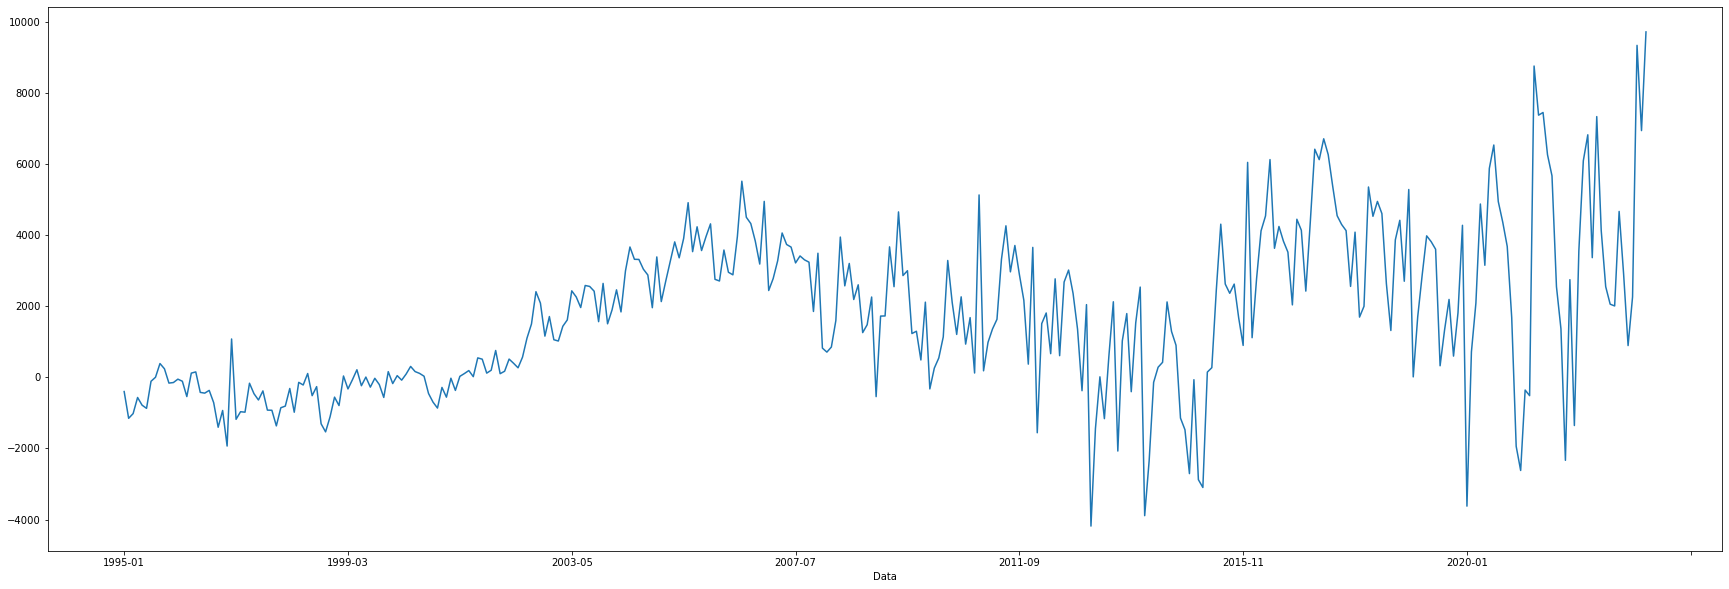

In [72]:
fig, axs = plt.subplots(figsize=(30,10))
balanca_novo['Saldo Balanca'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

## Implementando teste ADF ##

In [68]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

## Implementando teste KPSS ##

In [69]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Testando a série de balança comercial ##

In [71]:
adf_test(balanca_novo["Saldo Balanca"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.398814
p-value                          0.582845
#Lags Used                      14.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64


### Para o teste ADF, a hipótese nula é de uma raíz unitária, logo, para o valor da estatística do teste de -1.39, falhamos em rejeitar a hipótese nula, dado que estamos fora da região crítica. Assim, podemos concluir que a séria tem uma raíz unitária, a partir desse teste. ###

In [73]:
kpss_test(balanca_novo['Saldo Balanca'])

Results of KPSS Test:
Test Statistic            1.409952
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, a hipótese nula é de que a série não tem uma raíz unitária. Neste caso, a estatística do teste de 1.41 nós rejeitamos a hipótese nula, concluindo que a série tem uma raiz unitária. Logo, é não estacionária. ###


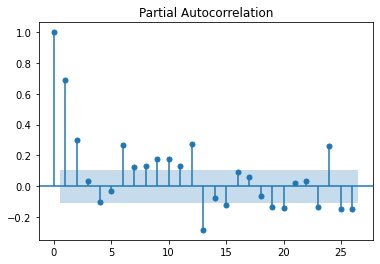

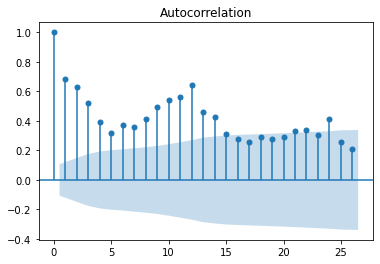

In [519]:
pacf_balanca = plot_pacf(balanca['Saldo Balanca'])
acf_balanca = plot_acf(balanca['Saldo Balanca'])

## Aqui, a partir da função de autocorrelação, é possível observar um possível comportamento sazonal da série, sendo assim, irei fazer o processo de retirar a sazonalidade da série e refazer os testes ##

In [76]:
result=seasonal_decompose(balanca_novo['Saldo Balanca'], model='additive', period=12)

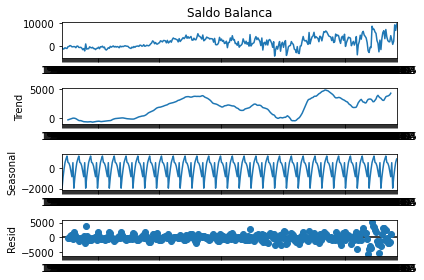

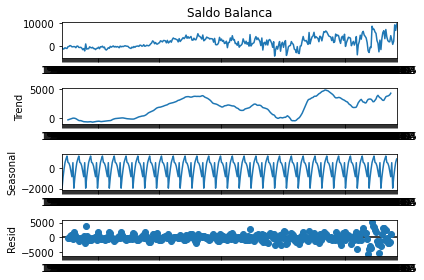

In [79]:
result.plot()

In [93]:
sazonalidade = result.seasonal
sazonalidade

Data
1995-01   -1958.478799
1995-02    -900.706367
1995-03    -121.393697
1995-04     519.177787
1995-05     859.050790
              ...     
2023-01   -1958.478799
2023-02    -900.706367
2023-03    -121.393697
2023-04     519.177787
2023-05     859.050790
Name: seasonal, Length: 341, dtype: float64

## Removendo a Sazonalidade ##

In [98]:
balanca_novo_dess = balanca_novo['Saldo Balanca'] - sazonalidade
balanca_novo_dess 


Data
1995-01    1559.750667
1995-02    -250.919339
1995-03    -898.090217
1995-04   -1084.867811
1995-05   -1640.750055
              ...     
2023-01    2853.167958
2023-02    3163.596469
2023-03    9461.645744
2023-04    6423.261767
2023-05    8859.681790
Length: 341, dtype: float64

In [121]:
df_balanca_dess = balanca_novo_dess.to_frame()

In [132]:
df_balanca_dess = df_balanca_dess.set_axis(['Saldo'], axis='columns')

In [133]:
df_balanca_dess

,Saldo
Data,
1995-01,1559.750667
1995-02,-250.919339
1995-03,-898.090217
1995-04,-1084.867811
1995-05,-1640.750055
...,...
2023-01,2853.167958
2023-02,3163.596469
2023-03,9461.645744


## Testando a série da balança comercial dessazonalidada ##

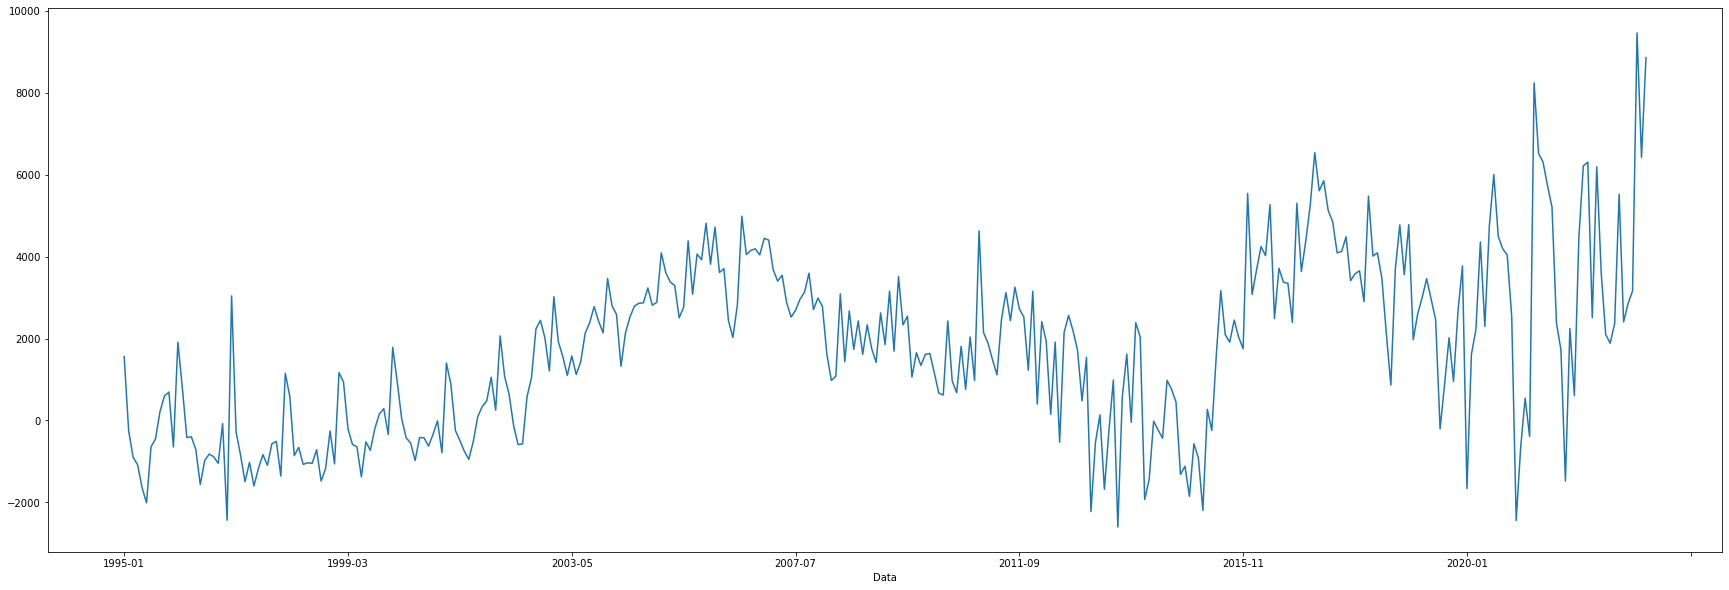

In [134]:
fig, axs = plt.subplots(figsize=(30,10))
df_balanca_dess['Saldo'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

## Funções de autocorrelação ##

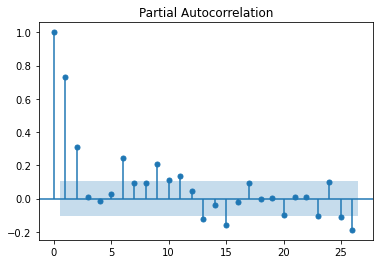

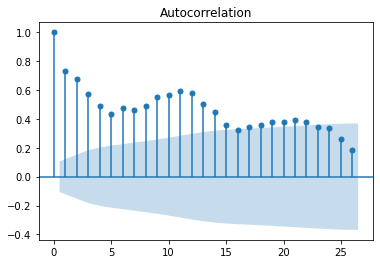

In [135]:
pacf_balanca_dess = plot_pacf(df_balanca_dess['Saldo'])
acf_balanca_dess = plot_acf(df_balanca_dess['Saldo'])

## 2. Cambio ##

In [242]:
cambio = pd.read_csv('cambio.csv', parse_dates=['Data'], sep = ';')
cambio

,Data,"Taxa de câmbio - R$ / US$ - comercial - compra - fim período - R$ - Banco Central do Brasil, Boletim, Seção Balanço de Pagamentos (Bacen / Boletim / BP) - BM12_ERCF12",Unnamed: 2
0,1953-01-01,"6,68363636363636E-15",NaN
1,1953-02-01,"1,49090909090909E-14",NaN
2,1953-03-01,"1,49090909090909E-14",NaN
3,1953-04-01,"1,41818181818182E-14",NaN
4,1953-05-01,"1,56363636363636E-14",NaN
...,...,...,...
840,2023-01-01,"5,0987",NaN
841,2023-02-01,"5,2072",NaN
842,2023-03-01,"5,0798",NaN
843,2023-04-01,"5,0001",NaN


In [243]:
cambio

,Data,"Taxa de câmbio - R$ / US$ - comercial - compra - fim período - R$ - Banco Central do Brasil, Boletim, Seção Balanço de Pagamentos (Bacen / Boletim / BP) - BM12_ERCF12",Unnamed: 2
0,1953-01-01,"6,68363636363636E-15",NaN
1,1953-02-01,"1,49090909090909E-14",NaN
2,1953-03-01,"1,49090909090909E-14",NaN
3,1953-04-01,"1,41818181818182E-14",NaN
4,1953-05-01,"1,56363636363636E-14",NaN
...,...,...,...
840,2023-01-01,"5,0987",NaN
841,2023-02-01,"5,2072",NaN
842,2023-03-01,"5,0798",NaN
843,2023-04-01,"5,0001",NaN


In [244]:
cambio = cambio.drop("Unnamed: 2", axis = 1)

In [245]:
cambio = cambio.rename(columns={cambio.columns[1]: 'Cambio'})

In [246]:
cambio

,Data,Cambio
0,1953-01-01,"6,68363636363636E-15"
1,1953-02-01,"1,49090909090909E-14"
2,1953-03-01,"1,49090909090909E-14"
3,1953-04-01,"1,41818181818182E-14"
4,1953-05-01,"1,56363636363636E-14"
...,...,...
840,2023-01-01,"5,0987"
841,2023-02-01,"5,2072"
842,2023-03-01,"5,0798"
843,2023-04-01,"5,0001"


In [247]:
cambio['Cambio'].describe()

count       845
unique      703
top       8E-13
freq         15
Name: Cambio, dtype: object

In [250]:
import datetime
data_inicio = datetime.datetime(1995, 1, 1)
data_final = datetime.datetime(2022, 1, 1)

cambio_filtrado = cambio[(data_inicio <= cambio["Data"]) &  (data_final > cambio["Data"])]

In [251]:
cambio_filtrado['Data'] = pd.to_datetime(cambio_filtrado['Data'], format='%Y-%m').dt.strftime('%Y-%m')

C:\Users\luizv\AppData\Local\Temp/ipykernel_40844/2825468921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cambio_filtrado['Data'] = pd.to_datetime(cambio_filtrado['Data'], format='%Y-%m').dt.strftime('%Y-%m')


In [252]:
cambio_filtrado

,Data,Cambio
504,1995-01,"0,84"
505,1995-02,"0,8495"
506,1995-03,"0,894"
507,1995-04,"0,911"
508,1995-05,"0,904"
...,...,...
823,2021-08,"5,1427"
824,2021-09,"5,4388"
825,2021-10,"5,6424"
826,2021-11,"5,6193"


In [264]:
cambio_filtrado.dtypes

Data      object
Cambio    object
dtype: object

In [269]:
cambio_filtrado['Cambio'] = cambio_filtrado['Cambio'].apply(lambda x: float(x.replace(".","").replace(",",".")))

C:\Users\luizv\AppData\Local\Temp/ipykernel_40844/2452852971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cambio_filtrado['Cambio'] = cambio_filtrado['Cambio'].apply(lambda x: float(x.replace(".","").replace(",",".")))


In [270]:
cambio_filtrado['Cambio'].astype(float)

504    0.8400
505    0.8495
506    0.8940
507    0.9110
508    0.9040
        ...  
823    5.1427
824    5.4388
825    5.6424
826    5.6193
827    5.5799
Name: Cambio, Length: 324, dtype: float64

In [271]:
cambio_filtrado

,Data,Cambio
504,1995-01,0.8400
505,1995-02,0.8495
506,1995-03,0.8940
507,1995-04,0.9110
508,1995-05,0.9040
...,...,...
823,2021-08,5.1427
824,2021-09,5.4388
825,2021-10,5.6424
826,2021-11,5.6193


In [292]:
cambio_filtrado = cambio_filtrado.set_index('Data')


KeyError: "None of ['Data'] are in the columns"

In [293]:
cambio_filtrado

,Cambio
Data,
1995-01,0.8400
1995-02,0.8495
1995-03,0.8940
1995-04,0.9110
1995-05,0.9040
...,...
2021-08,5.1427
2021-09,5.4388
2021-10,5.6424


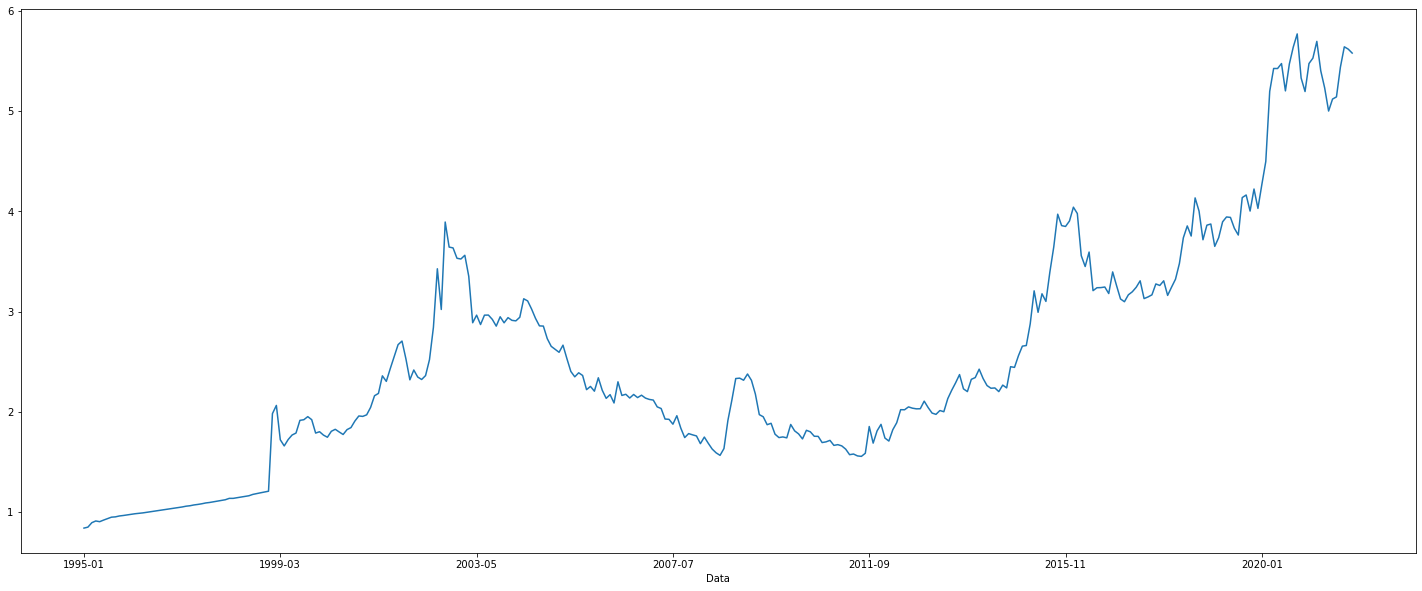

In [303]:
fig, axs = plt.subplots(figsize=(25,10))
cambio_filtrado['Cambio'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

## Teste da Raiz Unitária para a Taxa de Cambio #

In [275]:
adf_test(cambio_filtrado["Cambio"])

Results of Dickey-Fuller Test:
Test Statistic                  -0.051346
p-value                          0.954074
#Lags Used                       0.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64


### Para o Teste ADF, o valor da estatística de teste ficou em -0,05, fora da região crítica. Nesse caso, falhamos em rejeitar a hipótese nula que, para o teste ADF é de existir 1 raíz unitária. Sendo assim, há evidências de uma raíz unitária na série de câmbio. ###

In [276]:
kpss_test(cambio_filtrado['Cambio'])

Results of KPSS Test:
Test Statistic            1.612772
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, dado que a hipótese nula é de não possuir uma raíz unitária e para a estatística do teste de 1.61, rejeitamos a hipótese nula para todos os valores críticos e, assim, podemos concluir que a série é não estacionária ###

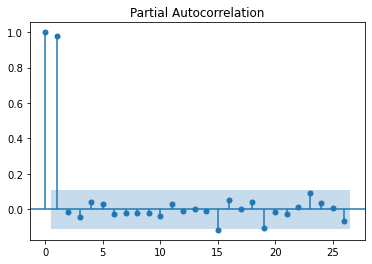

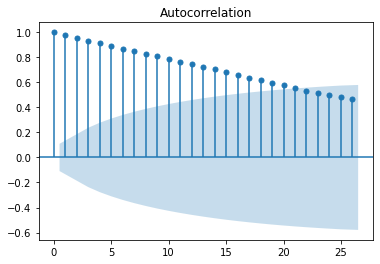

In [518]:
pacf_cambio = plot_pacf(cambio_filtrado['Cambio'])
acf_cambio = plot_acf(cambio_filtrado['Cambio'])

## 3. Taxa Selic ##


In [324]:
## Disponível em: https://www3.bcb.gov.br/sgspub/consultarvalores/consultarValoresSeries.do?method=getPagina ##

In [372]:
selic = pd.read_csv('taxa_selic.csv', sep = ';', index_col = 'Data')

In [373]:
selic

,"Taxa de juros - Over / Selic - (% a.a.) - Banco Central do Brasil, Sistema Gerenciador de Séries Temporais (Bacen Outras/SGS) - GM366_TJOVER366",Unnamed: 2
Data,,
04/06/1986,"17,8",NaN
05/06/1986,"18,5",NaN
06/06/1986,"18,3",NaN
07/06/1986,NaN,NaN
08/06/1986,NaN,NaN
...,...,...
19/06/2023,"13,65",NaN
20/06/2023,"13,65",NaN
21/06/2023,"13,65",NaN


In [374]:
selic = selic.rename(columns={'Taxa de juros - Over / Selic - (% a.a.) - Banco Central do Brasil, Sistema Gerenciador de Séries Temporais (Bacen Outras/SGS) - GM366_TJOVER366':'Selic'})

In [375]:
selic = selic.drop('Unnamed: 2', axis = 1)

In [376]:
selic

,Selic
Data,
04/06/1986,"17,8"
05/06/1986,"18,5"
06/06/1986,"18,3"
07/06/1986,NaN
08/06/1986,NaN
...,...
19/06/2023,"13,65"
20/06/2023,"13,65"
21/06/2023,"13,65"


In [382]:
selic.dtypes

Selic    object
dtype: object

In [383]:
selic["Selic"] = selic["Selic"].astype(str)
selic['Selic'] = selic['Selic'].apply(lambda x: str(x.replace(".","").replace(",",".")))

In [386]:
selic
selic.dtypes

Selic    object
dtype: object

In [389]:
selic["Selic"] = selic["Selic"].astype(float)
selic.dtypes

Selic    float64
dtype: object

In [396]:
selic.reset_index(inplace=True)

In [397]:
selic

,Data,Selic
0,04/06/1986,17.80
1,05/06/1986,18.50
2,06/06/1986,18.30
3,07/06/1986,NaN
4,08/06/1986,NaN
...,...,...
13529,19/06/2023,13.65
13530,20/06/2023,13.65
13531,21/06/2023,13.65
13532,22/06/2023,13.65


In [400]:
selic.dtypes

Data      object
Selic    float64
dtype: object

In [403]:
selic['Data'] = pd.to_datetime(selic['Data'], format='%d/%m/%Y')

In [404]:
import datetime
data_inicio = datetime.datetime(1995, 1, 1)
data_final = datetime.datetime(2022, 1, 1)

selic_filtrado = selic[(data_inicio <= selic["Data"]) &  (data_final > selic["Data"])]

In [405]:
selic_filtrado

,Data,Selic
3133,1995-01-01,NaN
3134,1995-01-02,47.37
3135,1995-01-03,47.12
3136,1995-01-04,47.12
3137,1995-01-05,47.12
...,...,...
12990,2021-12-27,9.15
12991,2021-12-28,9.15
12992,2021-12-29,9.15
12993,2021-12-30,9.15


In [406]:
selic_filtrado.set_index('Data')

,Selic
Data,
1995-01-01,NaN
1995-01-02,47.37
1995-01-03,47.12
1995-01-04,47.12
1995-01-05,47.12
...,...
2021-12-27,9.15
2021-12-28,9.15
2021-12-29,9.15


## 4. IBOVESPA ##

In [408]:
### Disponível em: https://br.investing.com/indices/bovespa-historical-data ###

In [460]:
ibov = pd.read_csv('Ibovespa.csv', sep = ',', encoding = 'utf-8')

In [461]:
ibov

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.12.2022,109.735,112.479,113.761,101.632,"307,11M","-2,45%"
1,01.11.2022,112.486,116.037,120.039,107.245,"339,62M","-3,06%"
2,01.10.2022,116.037,110.048,120.752,110.048,"301,26M","5,45%"
3,01.09.2022,110.037,109.524,114.392,106.244,"288,74M","0,47%"
4,01.08.2022,109.523,103.165,114.376,101.694,"297,13M","6,16%"
...,...,...,...,...,...,...,...
331,01.05.1995,3.721,3.814,4.185,3.689,"234,26B","-2,44%"
332,01.04.1995,3.814,2.979,3.924,2.867,"210,99B","28,02%"
333,01.03.1995,2.979,3.271,3.495,2.110,"242,62B","-8,92%"
334,01.02.1995,3.271,3.885,4.067,2.762,"179,37B","-15,81%"


In [462]:
ibov = ibov.drop(['Último', 'Máxima', 'Mínima', 'Vol.', 'Var%'],axis = 1)

In [463]:
ibov

,Data,Abertura
0,01.12.2022,112.479
1,01.11.2022,116.037
2,01.10.2022,110.048
3,01.09.2022,109.524
4,01.08.2022,103.165
...,...,...
331,01.05.1995,3.814
332,01.04.1995,2.979
333,01.03.1995,3.271
334,01.02.1995,3.885


In [464]:
ibov.dtypes

Data         object
Abertura    float64
dtype: object

In [465]:
ibov['Data'] = pd.to_datetime(ibov['Data'], format='%d.%m.%Y')

In [466]:
ibov.dtypes

Data        datetime64[ns]
Abertura           float64
dtype: object

In [467]:
ibov = ibov.set_index('Data')

In [468]:
ibov

,Abertura
Data,
2022-12-01,112.479
2022-11-01,116.037
2022-10-01,110.048
2022-09-01,109.524
2022-08-01,103.165
...,...
1995-05-01,3.814
1995-04-01,2.979
1995-03-01,3.271


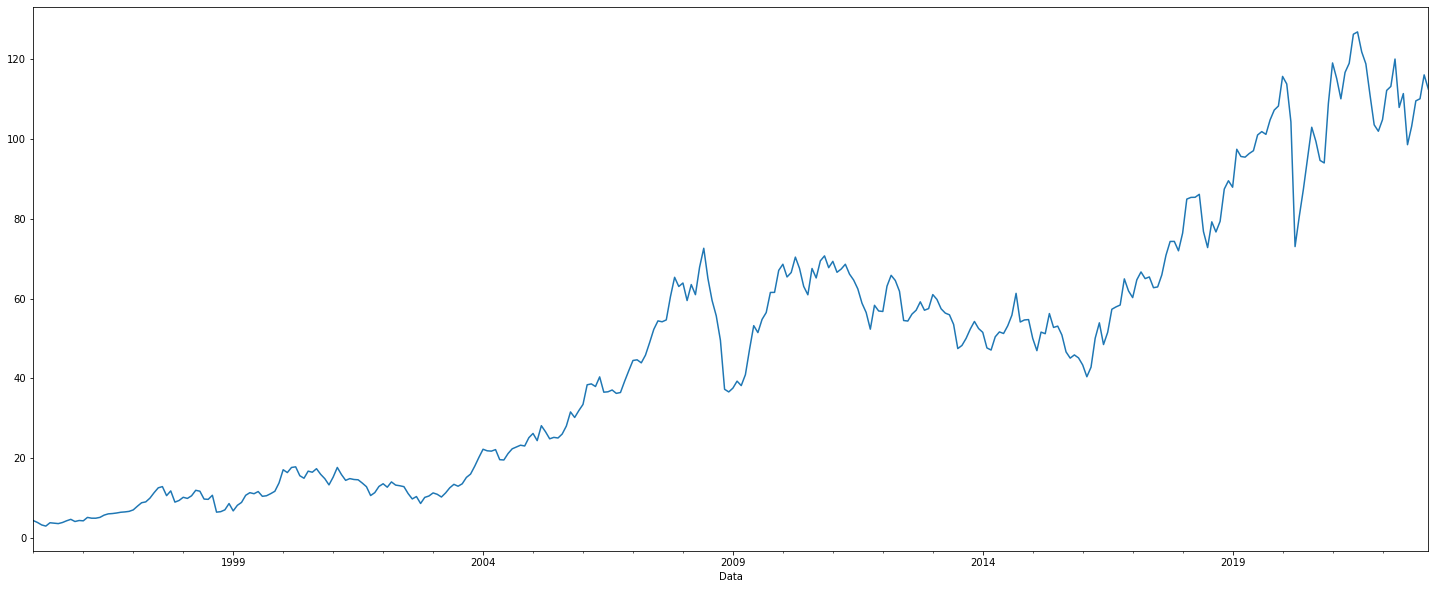

In [469]:
fig, axs = plt.subplots(figsize=(25,10))
ibov['Abertura'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

### Testes de Raíz Unitária ###

In [471]:
adf_test(ibov["Abertura"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.471854
p-value                          0.122474
#Lags Used                      17.000000
Number of Observations Used    318.000000
Critical Value (1%)             -3.451082
Critical Value (5%)             -2.870672
Critical Value (10%)            -2.571636
dtype: float64


### Para o teste ADF, o valor da estatística do teste é de -2.47, o que nos deixa fora da região crítica para todos os valores. Sendo assim, falhamos em rejeitar a hipótese nula, o que indica uma raíz unitária na série. ###

In [472]:
kpss_test(ibov['Abertura'])

Results of KPSS Test:
Test Statistic            2.546452
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, com o valor da estatística do teste de 2.54, dado que está dentro da região crítica para todas as significâncias, rejeitamos a hipótese nula, que é de não haver raíz unitária ###

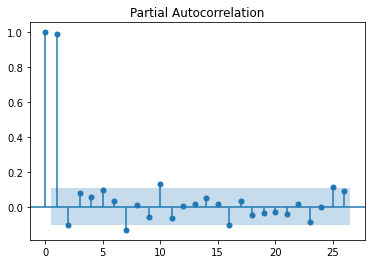

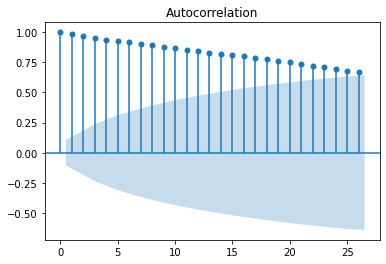

In [516]:
pacf_ibov = plot_pacf(ibov['Abertura'])
acf_ibov = plot_acf(ibov['Abertura'])

## 5. EMBI - Risco Brasil ##

In [473]:
### Disponível em: http://www.ipeadata.gov.br/Default.aspx ###

In [483]:
embi = pd.read_csv('embi.csv', sep = ';', encoding = 'utf-8')

In [484]:
embi

,Data,EMBI + Risco-Brasil - - - JP Morgan - JPM366_EMBI366,Unnamed: 2
0,29/04/1994,1120.0,NaN
1,30/04/1994,NaN,NaN
2,01/05/1994,NaN,NaN
3,02/05/1994,1131.0,NaN
4,03/05/1994,1081.0,NaN
...,...,...,...
10642,18/06/2023,NaN,NaN
10643,19/06/2023,NaN,NaN
10644,20/06/2023,231.0,NaN
10645,21/06/2023,231.0,NaN


In [485]:
embi = embi.drop('Unnamed: 2', axis = 1)

In [486]:
embi

,Data,EMBI + Risco-Brasil - - - JP Morgan - JPM366_EMBI366
0,29/04/1994,1120.0
1,30/04/1994,NaN
2,01/05/1994,NaN
3,02/05/1994,1131.0
4,03/05/1994,1081.0
...,...,...
10642,18/06/2023,NaN
10643,19/06/2023,NaN
10644,20/06/2023,231.0
10645,21/06/2023,231.0


In [487]:
embi = embi.rename(columns={'EMBI + Risco-Brasil - - - JP Morgan - JPM366_EMBI366': 'Embi'})

In [488]:
embi

,Data,Embi
0,29/04/1994,1120.0
1,30/04/1994,NaN
2,01/05/1994,NaN
3,02/05/1994,1131.0
4,03/05/1994,1081.0
...,...,...
10642,18/06/2023,NaN
10643,19/06/2023,NaN
10644,20/06/2023,231.0
10645,21/06/2023,231.0


In [489]:
embi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10647 entries, 0 to 10646
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    10647 non-null  object 
 1   Embi    7481 non-null   float64
dtypes: float64(1), object(1)
memory usage: 166.5+ KB


In [490]:
embi = embi.dropna(inplace = False, axis = 0)

In [491]:
embi

,Data,Embi
0,29/04/1994,1120.0
3,02/05/1994,1131.0
4,03/05/1994,1081.0
5,04/05/1994,1083.0
6,05/05/1994,1105.0
...,...,...
10639,15/06/2023,230.0
10640,16/06/2023,228.0
10644,20/06/2023,231.0
10645,21/06/2023,231.0


In [492]:
embi.dtypes

Data     object
Embi    float64
dtype: object

In [494]:
embi['Data'] = pd.to_datetime(embi['Data'], format='%d/%m/%Y')

C:\Users\luizv\AppData\Local\Temp/ipykernel_40844/2535128852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embi['Data'] = pd.to_datetime(embi['Data'], format='%d/%m/%Y')


In [495]:
embi

,Data,Embi
0,1994-04-29,1120.0
3,1994-05-02,1131.0
4,1994-05-03,1081.0
5,1994-05-04,1083.0
6,1994-05-05,1105.0
...,...,...
10639,2023-06-15,230.0
10640,2023-06-16,228.0
10644,2023-06-20,231.0
10645,2023-06-21,231.0


In [496]:
embi = embi.set_index('Data')

In [497]:
embi

,Embi
Data,
1994-04-29,1120.0
1994-05-02,1131.0
1994-05-03,1081.0
1994-05-04,1083.0
1994-05-05,1105.0
...,...
2023-06-15,230.0
2023-06-16,228.0
2023-06-20,231.0


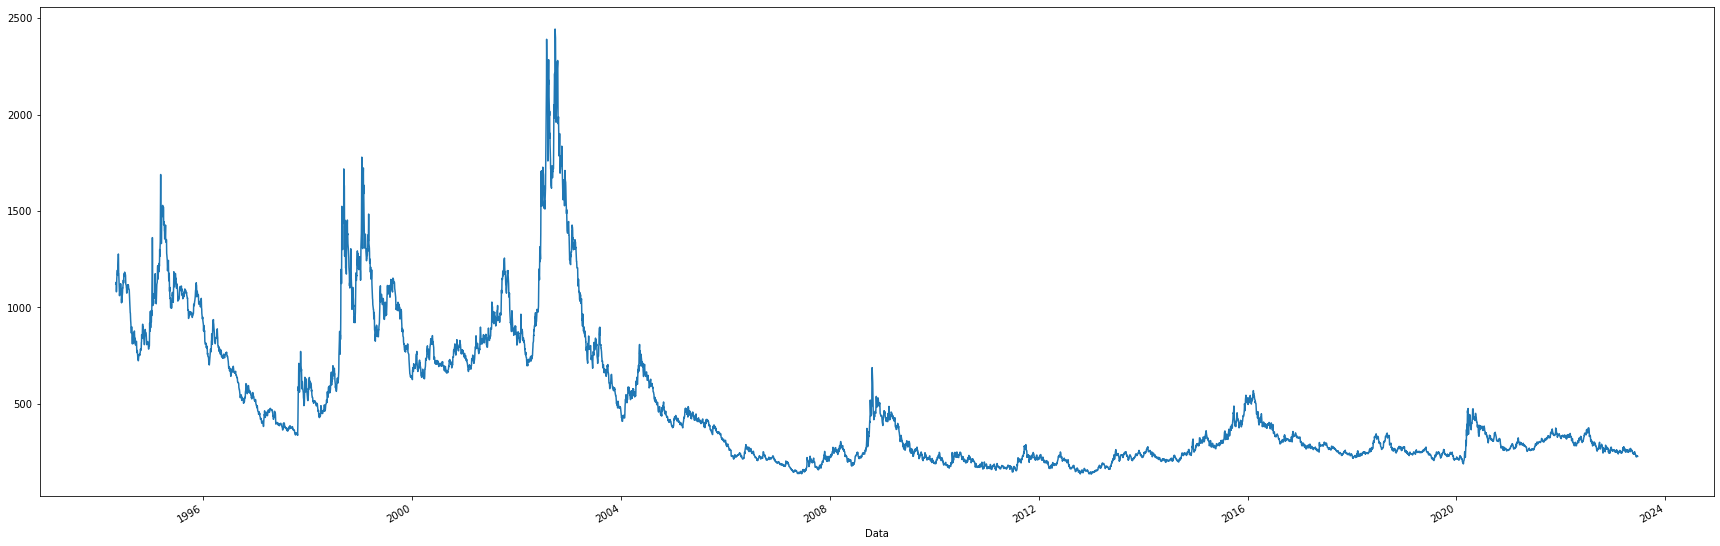

In [504]:
fig, axs = plt.subplots(figsize=(30,10))
embi['Embi'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

In [500]:
adf_test(embi["Embi"])

Results of Dickey-Fuller Test:
Test Statistic                   -3.022005
p-value                           0.032890
#Lags Used                       36.000000
Number of Observations Used    7444.000000
Critical Value (1%)              -3.431229
Critical Value (5%)              -2.861928
Critical Value (10%)             -2.566977
dtype: float64


### Para o teste ADF, para os valores críticos a níveis de 10 e 5%, rejeitamos a hipotese nula de uma raíz unitária e, para 1% falhamos em rejeitar a hipótese nula, indicando a existência de uma raíz unitária ###

In [502]:
kpss_test(embi['Embi'])

Results of KPSS Test:
Test Statistic            6.894638
p-value                   0.010000
Lags Used                53.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, rejeitamos a hipótese nula da série ser estacionária, indicando a existência de uma raíz unitária ###

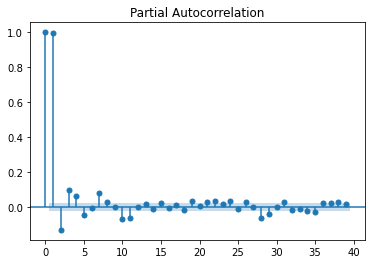

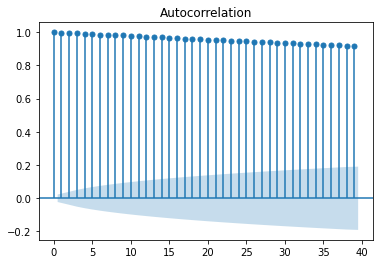

In [513]:
pacf_embi = plot_pacf(embi['Embi'])
acf_embi = plot_acf(embi['Embi'])